# Detection of Fake / Real Profiles

## Support Vector Machine and Random Forest

In [240]:
import sys
import csv
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime

import gender_guesser.detector as gender

from sklearn.preprocessing import Imputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn import metrics
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import RandomForestClassifier

In [241]:
def read_datasets():
    """ Reads users profile from csv files """
    real_users = pd.read_csv("data/users.csv")
    fake_users = pd.read_csv("data/fusers.csv")
    
    x = pd.concat([real_users,fake_users])    
    y = len(fake_users)*[0] + len(real_users)*[1]
    
    return x,y

In [242]:
def predict_sex(name):
    d = gender.Detector(case_sensitive=False)
    first_name= str(name).split(' ')[0]
    sex = d.get_gender(u"{}".format(first_name))
    
    sex_code_dict = {'female': -2, 'mostly_female': -1,'unknown':0, 'andy': 0, 'mostly_male':1, 'male': 2}
    code = sex_code_dict[sex]
    
    return code

In [243]:
def extract_features(x):
    lang_list = list(enumerate(np.unique(x['lang'])))
    
    lang_dict = { name : i for i, name in lang_list }             
    
    x.loc[:,'lang_code'] = x['lang'].map( lambda x: lang_dict[x]).astype(int)    
    x.loc[:,'sex_code'] = predict_sex(x['name'])
    
    feature_columns_to_use = ['statuses_count','followers_count','friends_count','favourites_count','listed_count','sex_code','lang_code']
    x = x.loc[:,feature_columns_to_use]
    
    return x

In [244]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    
    return plt

In [245]:
def plot_confusion_matrix(cm, title='CONFUSION MATRIX', cmap=plt.cm.Reds):
    target_names=['Fake','Genuine']
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [246]:
def train(X_train,y_train,X_test, nSplits, CV):
    """ Trains and predicts dataset with a SVM classifier """
    # Scaling features
    X_train = preprocessing.scale(X_train)
    X_test = preprocessing.scale(X_test)

    Cs = 10.0 ** np.arange(-2,3,.5)
    gammas = 10.0 ** np.arange(-2,3,.5)
    param = [{'gamma': gammas, 'C': Cs}]
    
    cvk = StratifiedKFold(n_splits= nSplits)
    
    classifier = SVC()
    
    clf = GridSearchCV(classifier, param_grid=param, cv=cvk)
    clf.fit(X_train,y_train)
    
    print("The best classifier is: ", clf.best_estimator_)
    clf.best_estimator_.fit(X_train, y_train)
    
    print()
    
    # Estimate score
    scores = cross_validate(clf.best_estimator_, X_train,y_train, cv=CV)
    
    for k in [*scores]:
        print(k + ": ", scores[k])
    
    print()
    
    print("Mean Training Score: {}".format(scores['train_score'].mean()))
    print("Mean Test Score: {}".format(scores['test_score'].mean()))
    
    title = 'Learning Curves (SVM, rbf kernel, gamma={})'.format(clf.best_estimator_.gamma)
    
    plot_learning_curve(clf.best_estimator_, title, X_train, y_train, cv=CV)
    plt.show()
    
    # Predict class
    y_pred = clf.best_estimator_.predict(X_test)
    
    return y_test,y_pred

In [247]:
x,y = read_datasets()
print("dataset read complete")

dataset read complete


In [248]:
x = extract_features(x)
print(x.columns)

Index(['statuses_count', 'followers_count', 'friends_count',
       'favourites_count', 'listed_count', 'sex_code', 'lang_code'],
      dtype='object')


In [249]:
# splitting train and test data
X_train,X_test,y_train,y_test = train_test_split(x, y, test_size=0.20, random_state=44)

/home/junaid/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  after removing the cwd from sys.path.
/home/junaid/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  """


The best classifier is:  SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=100.0, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

fit_time:  [0.09772205 0.09237146 0.09493017 0.09532809 0.09047914 0.13974118
 0.16315007]
score_time:  [0.01299119 0.00935078 0.00917244 0.01212001 0.00916076 0.01671124
 0.0124402 ]
test_score:  [0.91640867 0.94117647 0.92236025 0.9378882  0.9378882  0.96261682
 0.94392523]
train_score:  [0.96633868 0.96789228 0.96583851 0.96583851 0.9679089  0.96430419
 0.96740817]

Mean Training Score: 0.9665041791337039
Mean Test Score: 0.9374662630509122


/home/junaid/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


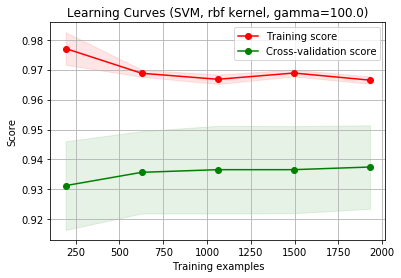

In [250]:
y_test,y_pred = train(X_train,y_train,X_test,5, 7)

Confusion matrix, without normalization
[[265   3]
 [ 53 243]]


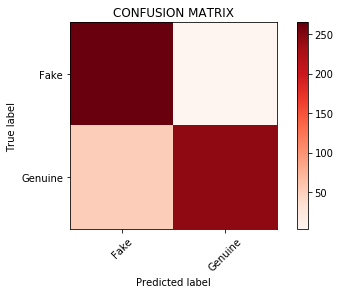

In [251]:
confusionMatrix = confusion_matrix(y_test, y_pred)
print('Confusion matrix, without normalization')
print(confusionMatrix)
plot_confusion_matrix(confusionMatrix)

In [252]:
print(classification_report(y_test, y_pred, target_names=['Fake','Genuine']))

              precision    recall  f1-score   support

        Fake       0.83      0.99      0.90       268
     Genuine       0.99      0.82      0.90       296

   micro avg       0.90      0.90      0.90       564
   macro avg       0.91      0.90      0.90       564
weighted avg       0.91      0.90      0.90       564



In [255]:
# RANDOM FOREST

rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
rf_classifier.fit(X_train, y_train)
train_predictions = rf_classifier.predict(X_train)
prediction = rf_classifier.predict(X_test)

In [258]:
err_training = mean_absolute_error(train_predictions, y_train)
err_test = mean_absolute_error(prediction, y_test)

print("Train Accuracy is : {}".format(100 - (100*err_training)))
print("Test Accuracy is : {}".format(100 - (100*err_test)))

Train Accuracy is : 93.74445430346051
Test Accuracy is : 93.08510638297872
